<br>

# My Solo project #1

<br>


<br>

### Exp1

The first exp will test to replicate one of the [Anthropic research outcome (Elhage et al., 2022)](https://transformer-circuits.pub/2022/toy_model/index.html) (see the left square box in the diagram below), compressing feature representations of a toy model from a larger dim into a smaller dim (2 dim) will lead to represent only two features (drawing approx 2 features orthogonally), when sparsity is not set (sparsity=0).

Here, 
- a toy model is composed of a one layer Linear model with a ReLU filtering function.
- compressing the toy model from a larger dim (49 dim) into a smaller dim (2 dim) via autoencoder model.
- training the toy model on the MNIST hand-written digit image (28x28) datasets.
- exploring if the datasets with the imagined 49 features will converge into 2 feature representations.

<br>


![alt text](../img/exp1_diagram1.png "Diagram1")


<br><br>


####################################################################################################
####################################################################################################
####################################################################################################
# 0-1. prepare packages
####################################################################################################
####################################################################################################
####################################################################################################

<br><br>


In [1]:
### import packages 

# ml/nn
import torch
import torch.nn as nn  # all neural network modules
import torch.nn.functional as F  # Functions with no parameters -> activation functions
import torch.optim as optim  # optimization algo

from torch.utils.data import DataLoader # easier dataset management, helps create mini batches
from torch.utils.data import random_split # set train-test ratio

# import torchvision
import torchvision.datasets as datasets  # standard datasets
import torchvision.transforms as transforms # this for convert dataset to tensor
from torchvision.utils import make_grid # this for visualization

# stats/ml #1
import numpy as np
import matplotlib.pyplot as plt

# stats/ml #2
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold


<br>
<br>


<br><br>


####################################################################################################
####################################################################################################
####################################################################################################
# 1-1. run exp
####################################################################################################
####################################################################################################
####################################################################################################

<br><br>


In [2]:
### set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
### Define all parameters

# later these will be inserted at the beginning as args

# fixed
batch_size = 64
input_size = 784
num_classes = 10
hidden_size2 = 2

# variable
hidden_size = 49
lr1 = 0.001  # lr for opt1 
lr2 = 0.0001 # lr for opt2 # 0.001, or etc 
num_epochs1 = 10
num_epochs2 = 20

In [4]:
### define original functions

def calculate_angle(x, y):
    # Calculate the angle in radians using arctan2
    radians = np.arctan2(y, x)  # y is vertical component, x is horizontal component
    # Convert radians to degrees
    degrees = np.degrees(radians)
    # Normalize the angle to the range [0, 360)
    angle = degrees % 360
    return angle

def norm_point(x, y):
    # Calculate the length of the vector
    length = np.sqrt(x**2 + y**2)
    
    # Check where length is 0
    zero_mask = (length == 0)  # Boolean mask for elements where length is 0

    # Initialize normalized coordinates
    x_norm = np.zeros_like(x)
    y_norm = np.zeros_like(y)
    
    # Perform normalization only where length != 0
    x_norm[~zero_mask] = x[~zero_mask] / length[~zero_mask]
    y_norm[~zero_mask] = y[~zero_mask] / length[~zero_mask]
    
    # For dimensions where length == 0, retain the original values
    x_norm[zero_mask] = x[zero_mask]
    y_norm[zero_mask] = y[zero_mask]

    return x_norm, y_norm

In [5]:
### implement two single FC NN models

class lin_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):  
        super(lin_model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input: 28x28=784, hidden: 7x7=49
        self.fc2 = nn.Linear(hidden_size, num_classes) # hidden: 49, num_classes: 10
    def forward(self, x):
        x = self.fc1(x) # 784->49
        x = torch.tanh(x) # range within [-1:1]
        x_h = F.relu(x) # add non-linearity
        x = self.fc2(x_h) # 49->10
        return x, x_h

class ae_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ae_model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input: 49, target_dim: 2, for visualising superposition in 2d
        self.fc2 = nn.Linear(hidden_size, input_size) # input: 2, target_dim: 49
    def forward(self, x):
        x = self.fc1(x) # 49->2
        x_2d = torch.tanh(x) # range within [-1:1]
        x = self.fc2(x_2d) # 2->49
        x = torch.tanh(x) # range within [-1:1]
        x = F.relu(x) # simulate lin_model's process
        return x, x_2d

In [6]:
# # define a SAE model

# # this will be added later

# class sae_model(nn.Module):
    
#     def __init__(self, in_dims, h_dims, sparsity_lambda=1e-4, sparsity_target=0.05):
#         super().__init__()
#         self.in_dims = in_dims
#         self.h_dims = h_dims
#         self.sparsity_lambda = sparsity_lambda # sparsity penalty impact
#         self.sparsity_target = sparsity_target # target sparsity distribution
        
#         self.encoder = nn.Sequential(
#             nn.Linear(self.in_dims, self.h_dims),
#             nn.Sigmoid() # range within [0:1]
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(self.h_dims, self.in_dims),
#             nn.Tanh() # range within [-1:1]
#         )
    
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

#     # kl divergence
#     def sparsity_penalty(self, encoded):
#         rho_hat = torch.mean(encoded, dim=0)
#         rho = self.sparsity_target
#         epsilon = 1e-8
#         rho_hat = torch.clamp(rho_hat, min=epsilon, max=1 - epsilon)
#         kl_divergence = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
#         sparsity_penalty = torch.sum(kl_divergence)
#         return self.sparsity_lambda * sparsity_penalty
    
#     def loss_function(self, x_hat, x, encoded):
#         mse_loss = F.mse_loss(x_hat, x)
#         sparsity_loss = self.sparsity_penalty(encoded)
#         return mse_loss + sparsity_loss

In [7]:
### define datasets

# load dataset
train_dataset = datasets.MNIST(root='../dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
### initialize model, loss, optimizer

m1 = lin_model(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_classes=num_classes
).to(device)

m2 = ae_model(
    input_size=hidden_size, 
    hidden_size=hidden_size2, 
    num_classes=num_classes
).to(device)

# Loss and Optimizer
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

opt1 = optim.Adam(m1.parameters(), lr=lr1) 
opt2 = optim.Adam(m2.parameters(), lr=lr2)

Epoch [1/10], loss1: 0.2355, accuracy: 0.9277


Epoch [2/10], loss1: 0.0865, accuracy: 0.9419


Epoch [3/10], loss1: 0.2696, accuracy: 0.9503


Epoch [4/10], loss1: 0.1911, accuracy: 0.9530


Epoch [5/10], loss1: 0.0844, accuracy: 0.9559


Epoch [6/10], loss1: 0.1387, accuracy: 0.9588


Epoch [7/10], loss1: 0.2276, accuracy: 0.9603


Epoch [8/10], loss1: 0.0427, accuracy: 0.9600


Epoch [9/10], loss1: 0.0200, accuracy: 0.9625


Epoch [10/10], loss1: 0.1132, accuracy: 0.9633


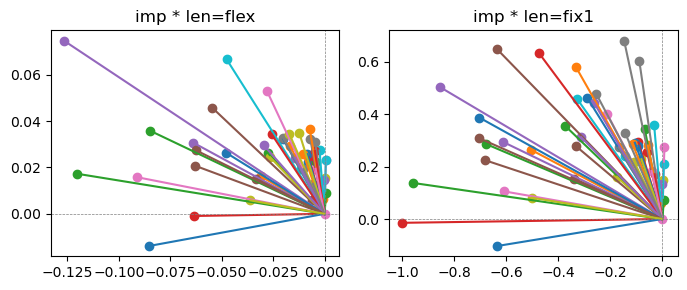

Epoch [1/20], loss2: 0.3069


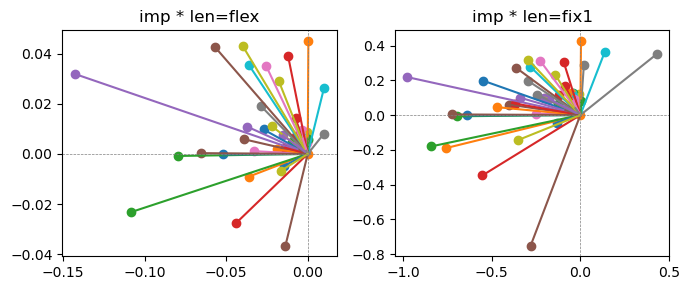

Epoch [2/20], loss2: 0.2868


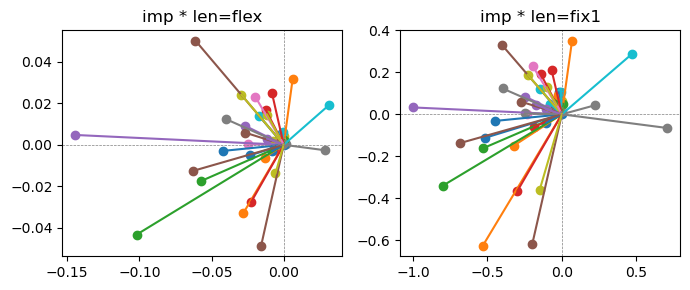

Epoch [3/20], loss2: 0.2776


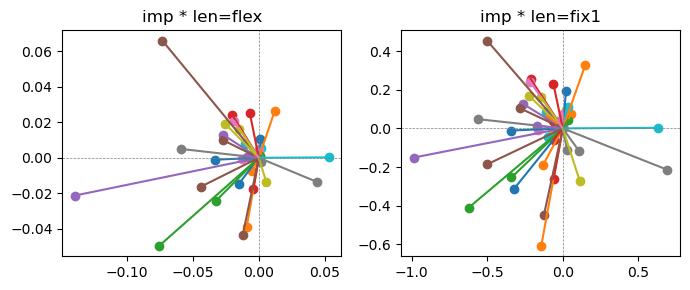

Epoch [4/20], loss2: 0.2704


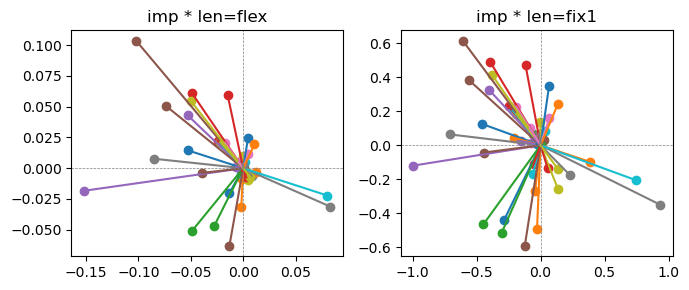

Epoch [5/20], loss2: 0.2756


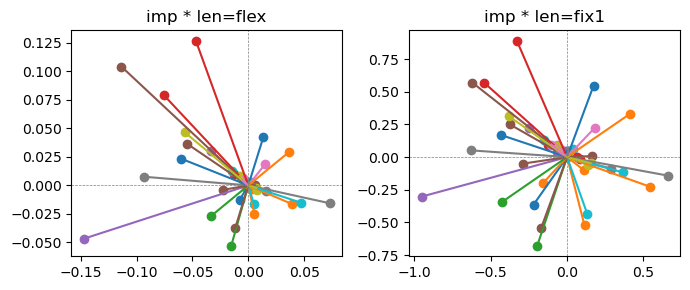

Epoch [6/20], loss2: 0.2516


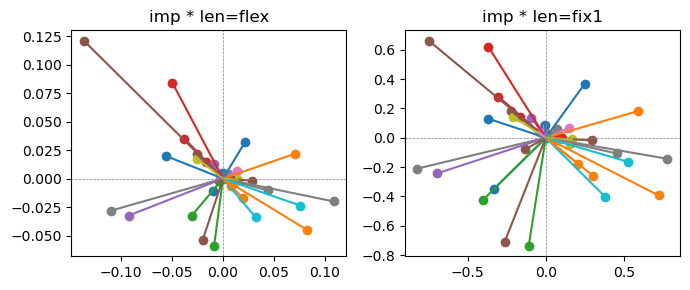

Epoch [7/20], loss2: 0.2363


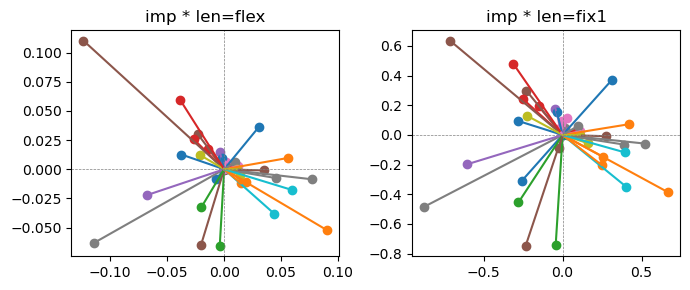

Epoch [8/20], loss2: 0.2084


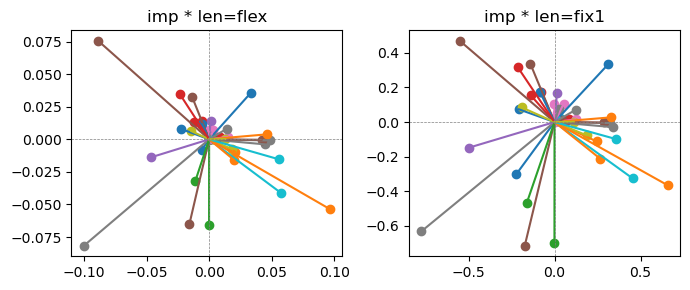

Epoch [9/20], loss2: 0.2132


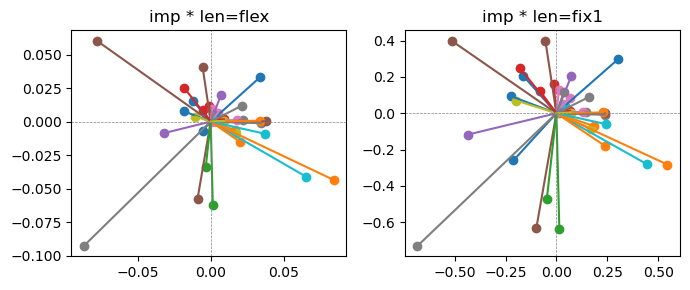

Epoch [10/20], loss2: 0.2086


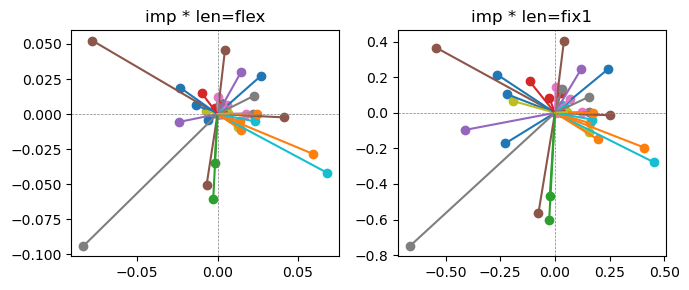

Epoch [11/20], loss2: 0.2023


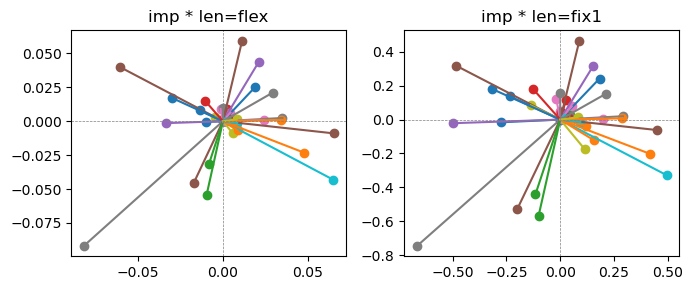

Epoch [12/20], loss2: 0.2058


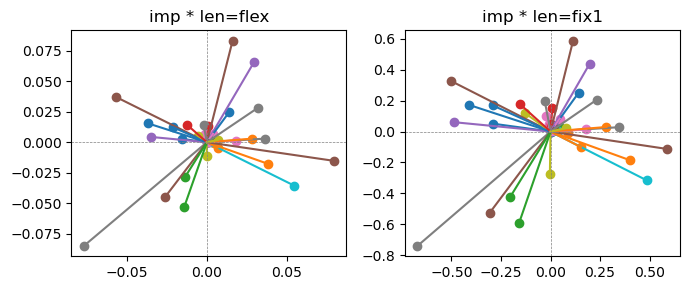

Epoch [13/20], loss2: 0.1913


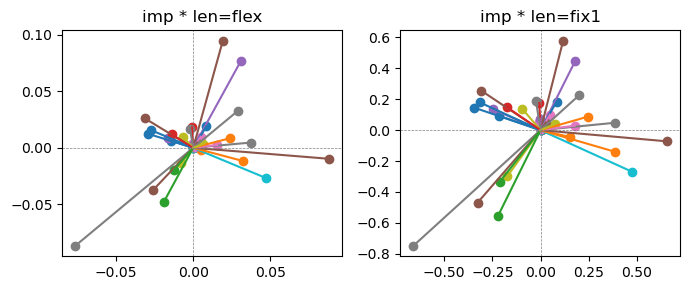

Epoch [14/20], loss2: 0.1981


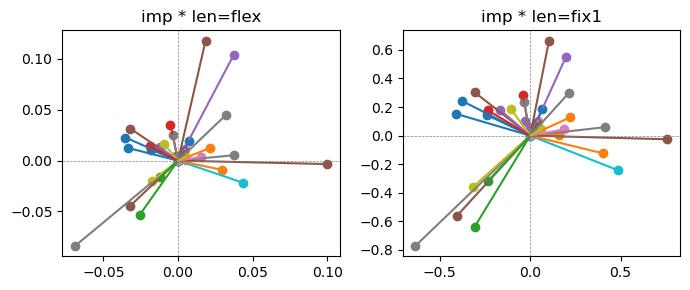

Epoch [15/20], loss2: 0.1886


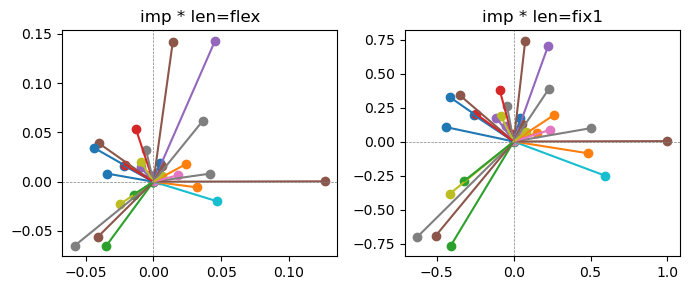

Epoch [16/20], loss2: 0.1890


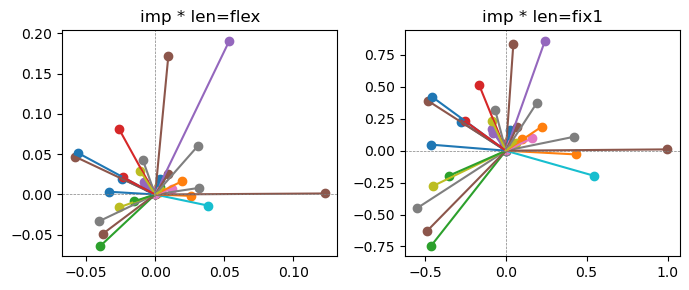

Epoch [17/20], loss2: 0.1850


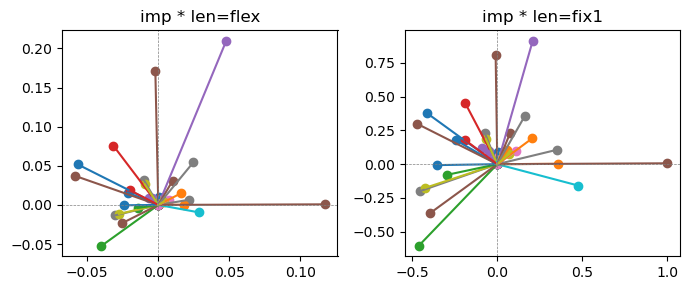

Epoch [18/20], loss2: 0.1822


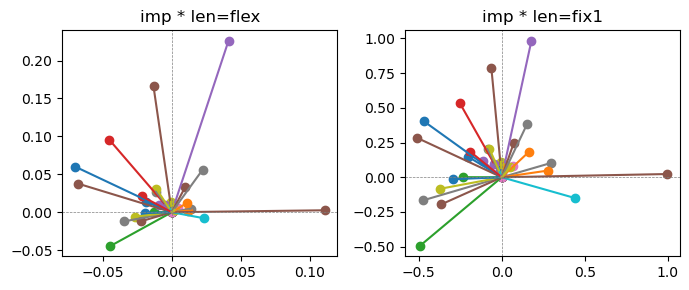

Epoch [19/20], loss2: 0.1823


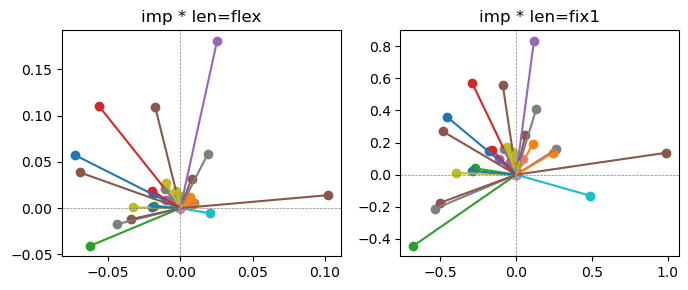

Epoch [20/20], loss2: 0.1731


In [9]:
### train and validaiton

num_epochs1 = 10
num_epochs2 = 20

###
### phase 1: prepare trained weights with larger dim
###

# training lin model
for epoch in range(num_epochs1):

    # Training
    for batch_idx, (data, targets) in enumerate(train_loader):

        # reshape [batch, 1, 28,28] to [batch, 28*28]
        data = data.reshape(-1, 28*28)

        # Step 1: Forward pass through model1
        out1, h1 = m1(data) # out1:[batch, 10] as 10 class, h1:[batch, 49] as 49 latent
        
        # Step 4: Compute loss1 and update model1
        loss1 = criterion1(out1, targets)
        opt1.zero_grad()
        loss1.backward()
        opt1.step()

    num_correct = 0
    num_samples = 0
    
    # Validation
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.reshape(-1, 28*28)
            out1, _ = m1(data)
            _, predictions = out1.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        accuracy = num_correct/num_samples
    
    print(f"Epoch [{epoch+1}/{num_epochs1}], loss1: {loss1.item():.4f}, accuracy: {accuracy.item():.4f}")

###
### phase 2: train AE model weights with 2 dim
###

# training ae model and visualize results
for epoch in range(num_epochs2):

    # Training autoencoder model
    for batch_idx, (data, targets) in enumerate(train_loader):

        # reshape [batch, 1, 28,28] to [batch, 28*28]
        data = data.reshape(-1, 28*28)

        with torch.no_grad():
            _, h1 = m1(data) # out1:[batch, 10] as 10 class, h1:[batch, 49] as 49 latent
            h1_clone = h1.detach()

        out2, _ = m2(h1_clone)  # 49 -> 2 -> 49

        loss2 = criterion2(out2, h1_clone)
        opt2.zero_grad()
        loss2.backward()
        opt2.step()

    # visualization
    with torch.no_grad():

        # Collecting data # lin model
        for batch_idx, (data, targets) in enumerate(train_loader):

            data = data.reshape(-1, 28*28)
            _, h1 = m1(data)
            
            if batch_idx == 0:
                target_h1 = h1
            else:
                target_h1 = torch.vstack((target_h1,h1))

        # Collecting data # ae model
        reconstruct_target_h1, h2_2d = m2(target_h1)
        
        # Collecting data # original loss
        target_loss2_orig = criterion2(reconstruct_target_h1, target_h1)

        # Importance and xy2d coord calculation        
        batch_size, large_model_dim = target_h1.shape
        importance = []
        target_dim_2d = []

        for one_dim in range(large_model_dim):

            # importance
            h1_perturb = target_h1.clone()
            h1_perturb[:,one_dim] = 0.0
            reconstruct_h1_perturb, _ = m2(h1_perturb)
            loss2_perturb = criterion2(reconstruct_h1_perturb, target_h1)
            importance.append(loss2_perturb - target_loss2_orig)

            # xy_2d
            target_h1_one_dim = torch.zeros_like(target_h1, dtype=torch.float) # batch, larger dim
            target_h1_one_dim[:,one_dim] = target_h1[:,one_dim]
            _, target_h1_2d = m2(target_h1_one_dim)
            target_dim_2d.append(target_h1_2d.mean(axis=0))
        
        target_dim_2d = np.array(target_dim_2d)
        
        # calculate importance according to contribution to MSE loss
        importance = np.array([imp/sum(importance) for imp in importance])
        # importance[importance<(1/large_model_dim)] = 0.0 # convert importance lower than expected contribution into 0
        importance_norm = (importance - np.min(importance)) / (np.max(importance) - np.min(importance)) # normalize value into 0-1 range

        # compute xy_coordinates

        # use raw xy2d with unrestricted magnitude vector as it is
        xy_coord = importance_norm[:, np.newaxis] * target_dim_2d # because calculate [large_dim,]*[large_dim,xy_coord]
        # xy_coord = xy_coord/np.abs(xy_coord).max() # adjust max magnitude to -1.0 to 1.0
        x_coord = xy_coord[:,0]
        y_coord = xy_coord[:,1]

        # set a magnitude of xy2d with 1
        x_coord_norm, y_coord_norm = norm_point(target_dim_2d[:,0], target_dim_2d[:,1])
        x_coord_norm = x_coord_norm * importance_norm
        y_coord_norm = y_coord_norm * importance_norm

        # graph visualization
        fig, ax = plt.subplots(1,2, figsize=(7,3))
        for i in range(len(x_coord)):
            ax[0].scatter(x_coord[i], y_coord[i])
            ax[0].plot([0,x_coord[i]],[0,y_coord[i]])
            ax[1].scatter(x_coord_norm[i], y_coord_norm[i])
            ax[1].plot([0,x_coord_norm[i]],[0,y_coord_norm[i]])

        ax[0].title.set_text(f"imp * len=flex")
        ax[0].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax[0].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax[1].title.set_text(f"imp * len=fix1")
        ax[1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax[1].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    print(f"Epoch [{epoch+1}/{num_epochs2}], loss2: {loss2.item():.4f}")


<br><br>

### Result1

- m1 = the one layer linear model outputing a hidden layer dim (49 dim) while training the 10 class hand-wrriten digit images (28x28 = 784 dim).
- m2 = the AE model training the larger hidden layer dim (49 dim) representing each feature in a smaller hidden layer dim (2 dim).
- the left boxes are graphs representing each of 49 features computed by m2 output (2 dim, xy coordinates) multiplying with its importance.
- the right boxes are graphs representing each of 49 features computed by a vector of m2 output (2 dim, xy coordinates) with fixed magnitude=1 multiplying with its importance.
- 49 features are aggregated into around 2 features over 20 epochs training.
- In the middle of epochs training, representations become random but gradually converge into 2 dim.

<br>



<br>

### Exp2

The second exp will test to replicate another [Anthropic research outcome (Elhage et al., 2022)](https://transformer-circuits.pub/2022/toy_model/index.html) (see the first column of the **ReLU Output Model** in the diagram below). Namely, testing if the top important features (2 dim) are clearly represented in the toy model compared to the remaining least important features (47 dim), when sparsity is not set (sparsity=0).

Here, 
- W in h = W * x is an AE transformation from x(49dim) to h(2dim).
- b is a bias in h = W * x + b.
- W<sup>T</sup> in x' = ReLU(W<sup>T</sup> * W * x + b) is a reconstruction from h(2dim) to x'(49 dim)
- W<sup>T</sup> * W represents cosine similarity matrix between features (48x48 matrix).
- ||$W_i$|| tests if each feature is clearly represented.
- $\sum_{j} (\hat{x}_i*x_j)^2$ calculates similarity of a target feature, $\hat{x}_i$, with the remaining features.


<br>


![alt text](../img/exp1_diagram2.png "Diagram2")

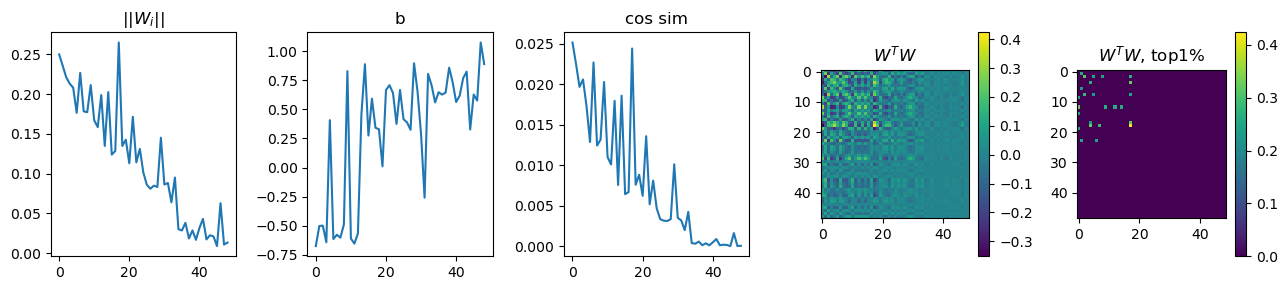

In [10]:
### demonstrate wT*w, W-norm, cos sim distance

with torch.no_grad():
    w1 = m2.fc1.weight.detach().numpy()
    w2 = m2.fc2.weight.detach().numpy()
    b1 = m2.fc1.bias.detach().numpy()
    b2 = m2.fc2.bias.detach().numpy()
    
    # Sort the columns of 'a' based on importance
    sorted_indices = np.argsort(importance_norm)[::-1] # Get indices that would sort the importance array
    w1_sorted = w1[:, sorted_indices] # Reorder the columns of 'a' based on sorted indices
    w2_sorted = w2[sorted_indices, :] # Reorder the columns of 'a' based on sorted indices
    b2_sorted = b2[sorted_indices][::-1] # Reorder the columns of 'a' based on sorted indices, and transpose as wT

    w1_sorted_t = w1_sorted.T
    mask_range = np.array(range(len(w1_sorted_t)))
    w1_cos_sim = []
    w2_cos_sim = []

    for i in range(len(w1_sorted_t)):
        w1_sorted_t_target = w1_sorted_t[i]
        idx_mask = (mask_range == i)
        w1_sorted_t_ref = w1_sorted_t[~idx_mask]
        cos_sim1 = ((w1_sorted_t_target @ w1_sorted_t_ref.T)**2).sum()
        w1_cos_sim.append(cos_sim1)

        w2_sorted_target = w2_sorted[i]
        idx_mask = (mask_range == i)
        w2_sorted_ref = w2_sorted[~idx_mask]
        cos_sim2 = ((w2_sorted_ref @ w2_sorted_target)**2).sum()
        w2_cos_sim.append(cos_sim2)

    w1_cos_dis = np.array(w1_cos_sim)
    w2_cos_dis = np.array(w2_cos_sim)

    x = w1_sorted.T[:,0]
    y = w1_sorted.T[:,1]
    w_norm = np.sqrt(x**2 + y**2)

    wtw = (w2_sorted @ w1_sorted)
    # wtw = (w_sorted.T @ w_sorted)

    wtw_clone = wtw.copy()
    thres = np.percentile(wtw_clone, [99])
    wtw_clone[wtw_clone<thres] = 0.0

    fig, ax = plt.subplots(1,5, figsize=((13,3)))

    ax[0].plot(w_norm) # ||Wi||
    ax[1].plot(b2_sorted) # b    
    ax[2].plot(w1_cos_dis) # cos sim
    pos1 = ax[3].imshow(wtw)
    pos2 = ax[4].imshow(wtw_clone)

    ax[0].title.set_text(f"||$W_{'i'}$||")
    ax[1].title.set_text(f"b")
    ax[2].title.set_text(f"cos sim")
    ax[3].title.set_text(f"$W^TW$")
    ax[4].title.set_text(f"$W^TW$, top1%")

    fig.colorbar(pos1)
    fig.colorbar(pos2)

    plt.tight_layout()
    # plt.savefig("img.png")
    plt.show()


<br><br>

### Result2

- x axis of all graphs here is importance ranks of features, 0th as the highest and 48th as the lowest. 
- higher ||Wi|| as its importance is higher.
- larger b as importance is reduced.
- cos sim: everything is around 0.
- $W^TW$ shows a higher similarity as the feature importance is higher.

<br>


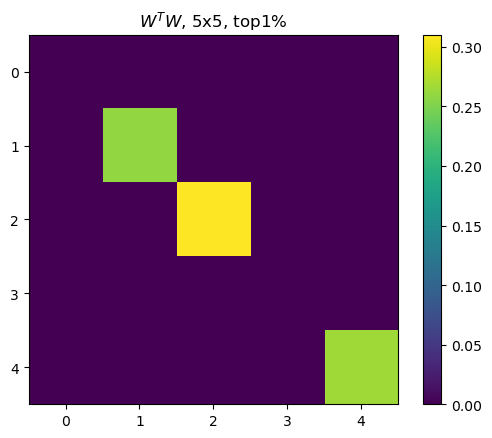

In [11]:
pos = plt.imshow(wtw_clone[:5,:5])
plt.colorbar(pos)
plt.title(f"$W^TW$, 5x5, top1%")
plt.show()